In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import geopandas as gpd
from functools import reduce

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
YEARS = ['2022']
OFFICES = ['US_House']

In [73]:
census_datasets = [
    'b02001_race', 'b04007_ancestry', 'b05012_nativity_us', 'b08303_travel_time_work', 
    'b25003_housing_rentership', 'dp04_housing_characteristics', 'dp05_age_race', 's0101_age_sex', 
    's1101_households_families', 's1201_marital_status', 's1501_educational_attainment', 's1701_income_poverty', 
    's1903_median_income', 's2101_veteran_status', 's2201_food_stamps', 's2301_employment_status', 
    's2401_occupation_sex', 's2403_industry_sex', 's2501_occupancy_characteristics', 
    's2503_financial_characteristics', 's2701_health_insurance',
]

def calcPartisanChange(row):
    change = row["rep_share_change"] - row["dem_share_change"]
    return change

for year in YEARS:
    print(f'Processing year {year}')
    
    for office in OFFICES:
        print(f'Processing office {office}')
        
        df_precincts = pd.read_csv('data/generated_data/df_06_tract_' + year + '_' + office + '.csv')
        df_precincts['standardized_id_num'] = df_precincts['standardized_id_num'].astype(str).str.zfill(13)

        print(f'Loading census data')
        census_dataset_dfs = []
        for census_dataset in census_datasets:
            census_dataset = census_dataset.lower()
            if census_dataset[:1] == 's':
                census_dataset_code = census_dataset[:5].upper()
                census_dataset_label = census_dataset[6:]
            elif census_dataset[:1] == 'b':
                census_dataset_code = census_dataset[:6].upper()
                census_dataset_label = census_dataset[7:]
            
            df_census_dataset = pd.read_csv(f'data/generated_data/df_06_{census_dataset_label}_' + year + '_' + office + '.csv')
            df_census_dataset.rename(columns={f'geoid_{census_dataset_label}': 'geoidfq_tract'}, inplace=True)
            
            census_dataset_dfs.append(df_census_dataset)

        dfs = [df_precincts]
        dfs.extend(census_dataset_dfs)
        
        df = reduce(lambda left, right: pd.merge(left, right, on='geoidfq_tract', how='left'), dfs)
        df['standardized_id_num'] = df['standardized_id_num'].astype(str).str.zfill(13)

        drop_cols = [
            "City/Township Description", "District Code", "Election Type",
            "Michigan County Code",
            "Office Description", "Precinct Label", "Status Code",
            "County Name", "Precinct Number", "Election Year",
            "total_votes", "registered_voters", "turnout_pct",
            "nearest_bound_census_tract", "nearest_bound_school_district", "nearest_bound_zipcode",
            "Office Code", "Census County Code",
            "City/Township Code", "Ward Number",
            "county", "office", "electionye",
            "registered_voters_change",
            "dem_votes", "rep_votes", "oth_votes",
            "dem_share", "rep_share", "oth_share",
            "locale_full", "objectid", "precinct_num", "precinct_wp_id",
            "standardized_id", "geometry", "geometry_tract", "geoidfq_tract", "name_tract",
            "subdivision_fips", "ward_num", "locale_full", "county_fips", "objectid", "precinct_num",
            "nearest_tract", "awater_tract", "aland_tract", "tractce_tract", "shapestarea", "shapestlength", "geoid_tract",
        ]
        df = df.drop(columns=drop_cols, errors='ignore')
        
        string_columns = ["standardized_id_num"]
        string_df = df[string_columns]

        # Force numeric
        numeric_df = df.drop(columns=string_columns, errors='ignore')
        numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
        numeric_df = numeric_df.fillna(numeric_df.median())
        
        df = pd.concat([string_df, numeric_df], axis=1)

        df['standardized_id_num'] = df['standardized_id_num'].astype(str).str.zfill(13)

        df["partisanship_change_amount"] = df.apply(lambda row: calcPartisanChange(row), axis=1)

Processing year 2022
Processing office US_House
Loading census data


In [109]:
# Target and features
y = df[['partisanship_change_amount']]
X = df.drop(columns=['standardized_id_num', 'partisanship_change_amount'])

# Drop all-nan columns
X = X.dropna(axis=1, how='all')

# These confound results
X = X.drop(columns=[
    'dem_share_prev', 'rep_share_prev', 'oth_share_prev', 
    'dem_votes_change', 'rep_votes_change', 'oth_votes_change', 
    'turnout_pct_change'
])

X.sample(3)

dem_share_change  rep_share_change  oth_share_change  B02001_001E  \
2808          0.047491         -0.047491               0.0       3711.0   
1702          0.011902         -0.011902               0.0       3254.0   
1921          0.020751         -0.020751               0.0       2424.0   

      B02001_002E  B02001_003E  B02001_004E  B02001_005E  B02001_006E  \
2808       2921.0        196.0          0.0        424.0          0.0   
1702       2573.0        136.0          0.0         11.0          0.0   
1921       1951.0        268.0          0.0        139.0          7.0   

      B02001_007E  B02001_008E  B02001_009E  B02001_010E  B04007_001E  \
2808         56.0        114.0         15.0         99.0       3711.0   
1702          8.0        122.0         31.0         71.0       3254.0   
1921          0.0         59.0         12.0         47.0       2424.0   

      B04007_002E  B04007_003E  B04007_004E  B04007_005E  B04007_006E  \
2808       2827.0       1522.0       1305.0        884.0         53.0   
1702       2460.0       1403.0        954.0        675.0         69.0   
1921       2131.0       1600.0        531.0        293.0          7.0   

      B04007_007E  B05012_001E  B05012_002E  B05012_003E  B08303_001E  \
2808        831.0       3711.0       3273.0        438.0       2268.0   
1702        591.0       3254.0       3050.0         68.0       1317.0   
1921        286.0       2424.0       1895.0        529.0        903.0   

      B08303_002E  B08303_003E  B08303_004E  B08303_005E  B08303_006E  \
2808         16.0        271.0        276.0        163.0        676.0   
1702         28.0        109.0        154.0        168.0        158.0   
1921          7.0         75.0         96.0        176.0        172.0   

      B08303_007E  B08303_008E  B08303_009E  B08303_010E  B08303_011E  \
2808        153.0        488.0         36.0         59.0         84.0   
1702         73.0        137.0         28.0         34.0         68.0   
1921         71.0         96.0         10.0         14.0         71.0   

      B08303_012E  B08303_013E  S0101_C01_001E  S0101_C01_002E  \
2808         33.0         13.0          3711.0            70.0   
1702         39.0         15.0          3254.0           149.0   
1921         80.0         35.0          2424.0            62.0   

      S0101_C01_003E  S0101_C01_004E  S0101_C01_005E  S0101_C01_006E  \
2808           141.0            67.0            75.0           489.0   
1702           165.0           179.0           179.0           163.0   
1921           125.0           141.0           160.0           105.0   

      S0101_C01_007E  S0101_C01_008E  S0101_C01_009E  S0101_C01_010E  \
2808           898.0           371.0           234.0           130.0   
1702           178.0           177.0           176.0           171.0   
1921           125.0           119.0           213.0            78.0   

      S0101_C01_011E  S0101_C01_012E  S0101_C01_013E  S0101_C01_014E  \
2808           186.0           142.0           187.0           220.0   
1702           176.0           203.0           216.0           231.0   
1921           211.0           146.0           119.0           127.0   

      S0101_C01_015E  S0101_C01_016E  S0101_C01_017E  S0101_C01_018E  \
2808           181.0           177.0           101.0            32.0   
1702           191.0           153.0            96.0            55.0   
1921           167.0           135.0           144.0            96.0   

      S0101_C01_019E  S0101_C01_020E  S0101_C01_021E  S0101_C01_022E  \
2808            10.0           208.0            37.0           315.0   
1702            52.0           357.0           110.0           648.0   
1921           151.0           266.0           100.0           428.0   

      S0101_C01_023E  S0101_C01_024E  S0101_C01_025E  S0101_C01_026E  \
2808           527.0          2197.0          3421.0          3396.0   
1702           233.0          1151.0          2673.0          2595.0   
1921           165.0 

In [110]:
from sklearn.impute import SimpleImputer

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # or 'median'
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', numeric_transformer, numeric_cols)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.152946687974667e-05


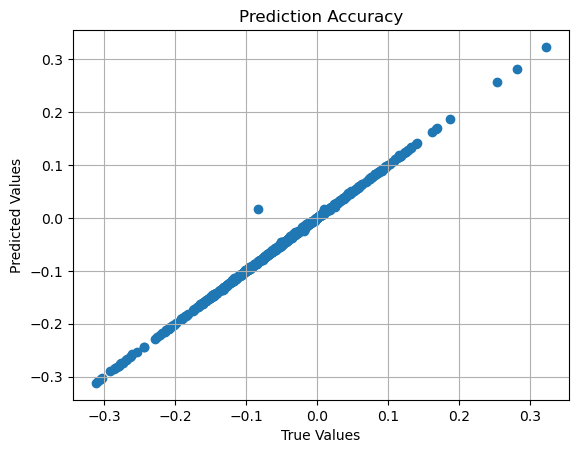

In [111]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Accuracy")
plt.grid(True)
plt.show()

### Feature analysis

In [124]:
top_n = 25

In [125]:
# model.fit(X_train, y_train)  # happens above

sort_column = 'coefficient' # in order of positive predictive power

coefficients = model.named_steps['regressor'].coef_.flatten()
feature_names = numeric_cols

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values(by=sort_column, ascending=False)

print(coef_df.head(top_n))

               feature  coefficient  abs_coefficient
1     rep_share_change     0.041911         0.041911
13         B04007_001E     0.015014         0.015014
10         B02001_008E     0.014337         0.014337
63      S0101_C01_028E     0.009389         0.009389
17         B04007_005E     0.007830         0.007830
2299    S2701_C01_019E     0.005624         0.005624
2360    S2701_C02_019E     0.005291         0.005291
115     S0101_C03_012E     0.005232         0.005232
20         B05012_001E     0.004643         0.004643
6          B02001_004E     0.004585         0.004585
177     S0101_C05_012E     0.004446         0.004446
14         B04007_002E     0.004265         0.004265
119     S0101_C03_016E     0.004106         0.004106
134     S0101_C03_031E     0.003395         0.003395
723     S1501_C05_028E     0.003236         0.003236
498     S1501_C01_009E     0.003187         0.003187
600     S1501_C03_008E     0.002983         0.002983
975     S2101_C03_001E     0.002960         0.

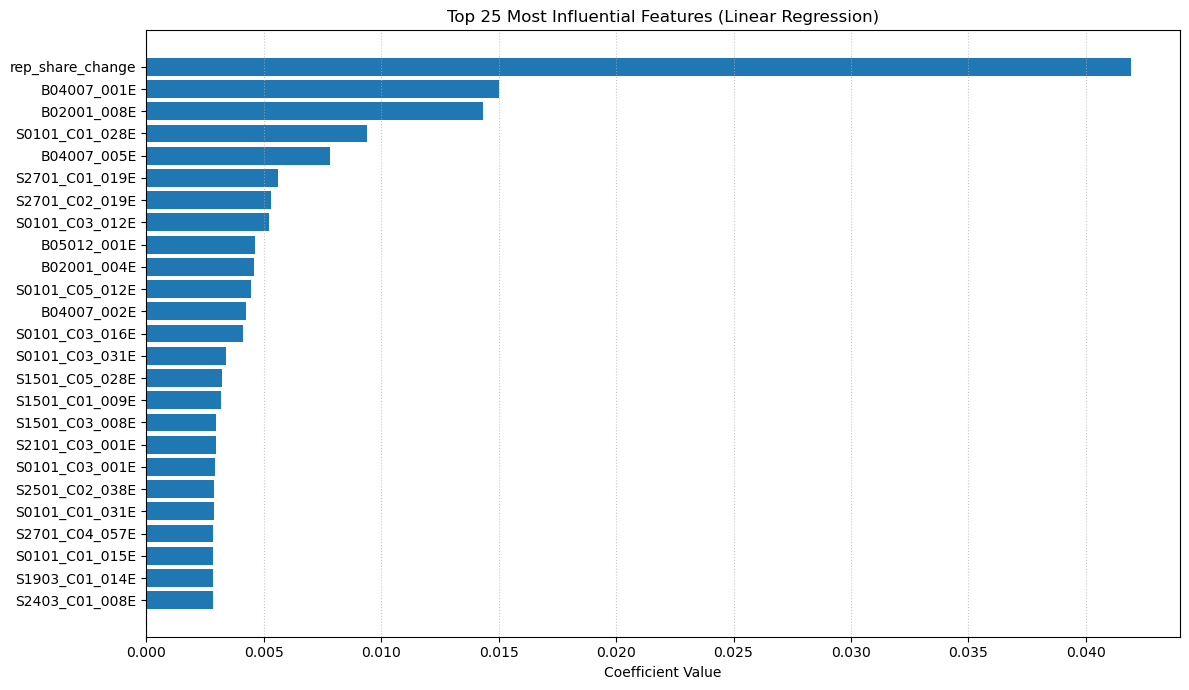

In [126]:
top_features = coef_df[coef_df['coefficient'] > 0].sort_values(by='coefficient', ascending=False).head(top_n)

plt.figure(figsize=(12, 7))
bars = plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Most Influential Features (Linear Regression)')
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(True, axis='x', linestyle=':', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Predict all data

In [127]:
model.fit(X, y)
y_pred_all = model.predict(X)

mse = mean_squared_error(y, y_pred_all)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.587705480175502e-30


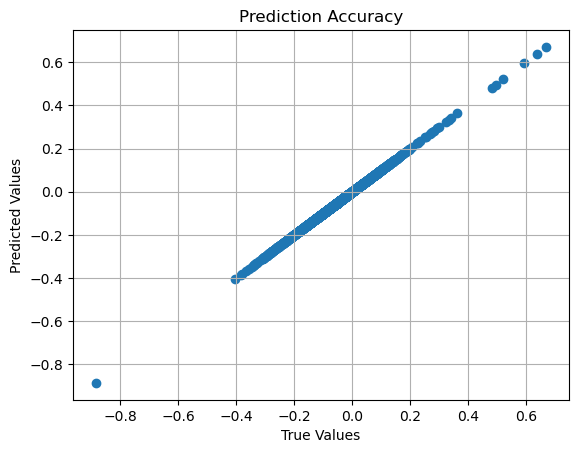

In [128]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred_all)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Accuracy")
plt.grid(True)
plt.show()